In [1]:
#import libraries
import keras
import pandas as pd
import os
import tensorflow as tf
from keras.applications.mobilenet_v2 import preprocess_input
import keras
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
#add mobilenetv2 model
from keras.optimizers import Adam
from keras.applications import MobileNet
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [3]:
#Difine The Variables
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
CHANNELS = 3
num_classes = 38

In [4]:
train_image_path="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"
valid_image_path="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/"
test_image_path="/kaggle/input/new-plant-diseases-dataset/test/"

In [5]:
# Applying Data Augmentation Techniques 
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    
    # Additional augmentations
    brightness_range=[0.8, 1.2],  # Adjust brightness by a random factor
    channel_shift_range=0.1,      # Randomly shift the values of the channels
    rescale=1./255,               # Rescale pixel values from [0, 255] to [0, 1]
    samplewise_center=True,       # Set each sample mean to 0
    samplewise_std_normalization=True,  # Divide each input by its standard deviation
)

In [6]:
train_generator = train_datagen.flow_from_directory(
        train_image_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    class_mode='categorical'
)


Found 70295 images belonging to 38 classes.


In [15]:
#Creating generator for Validation DataSet
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory(
        valid_image_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        seed=42
)

Found 17572 images belonging to 38 classes.


In [ ]:
#Creating generator for Test DataSet
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
        test_image_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
)

In [8]:
print(train_generator.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

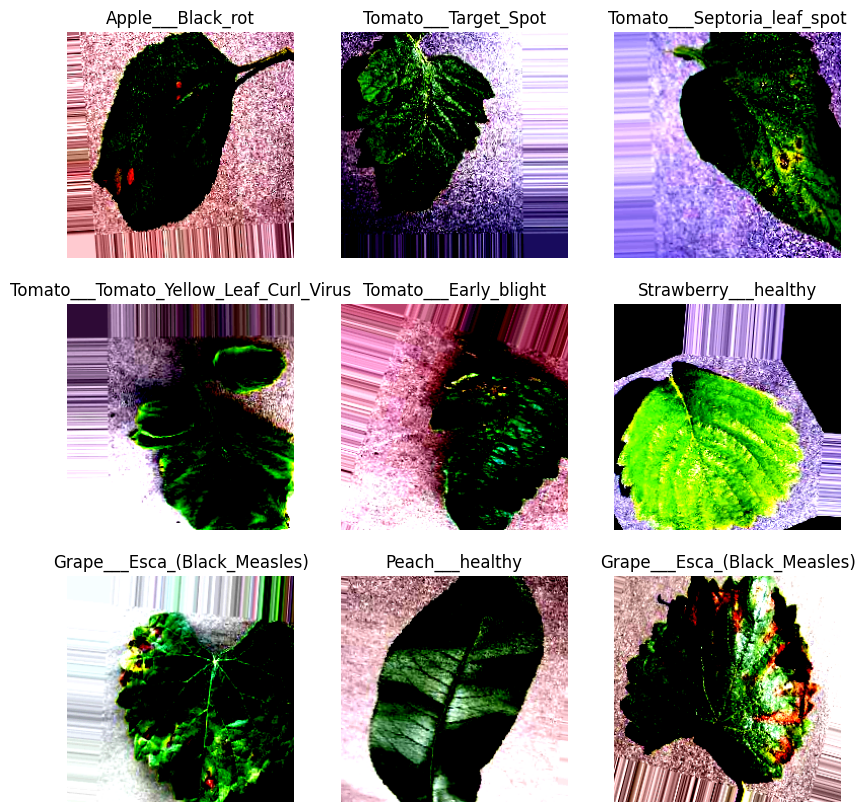

In [13]:
#visualize the data
import matplotlib.pyplot as plt
import numpy as np

# Get the class names
class_names = list(train_generator.class_indices.keys())

# Get a batch of images
images, labels = next(train_generator)

# Visualize the images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.show()


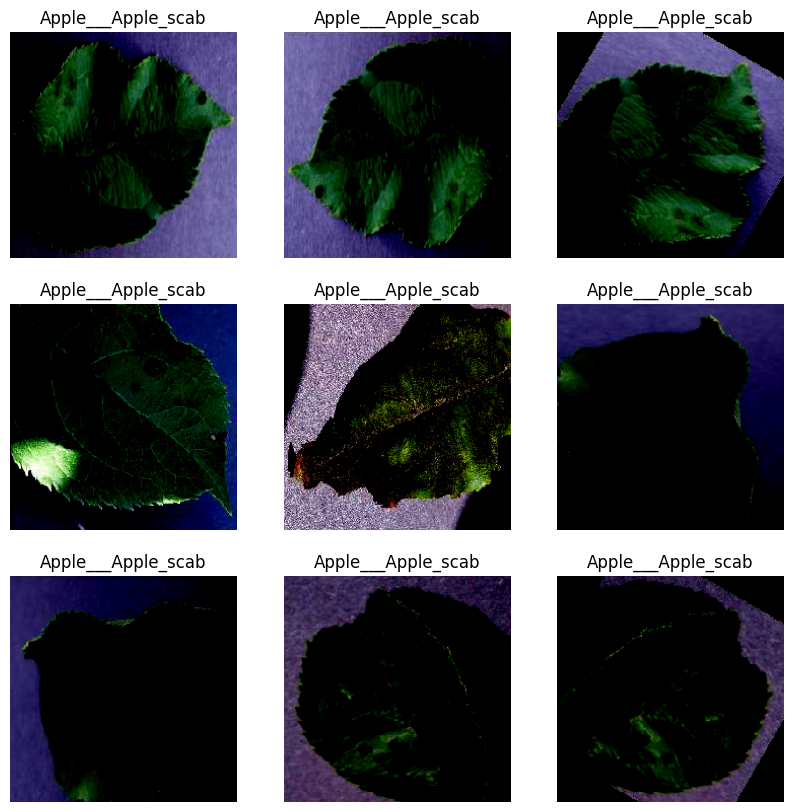

In [16]:
#visualize the data from validation
import matplotlib.pyplot as plt
import numpy as np

# Get the class names
class_names = list(val_generator.class_indices.keys())

# Get a batch of images
images, labels = next(val_generator)

# Visualize the images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.show()

In [17]:
# Define the MobileNetV2 model
base_model_mobilenet= tf.keras.applications.MobileNetV2 (weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to prevent overfitting
for layer in base_model_mobilenet.layers[:-100]:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
from keras.models import Model
from keras.regularizers import l2
# Assuming base_model_mobilenet is already defined
dropout_rate=0.3
x = base_model_mobilenet.layers[-6].output
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(dropout_rate)(x)
x = Flatten()(x)  # Flatten the feature maps
x = Dense(64, activation='relu')(x)
x = Dropout(dropout_rate)(x)
predictions_mobilenet = Dense(num_classes, activation='softmax',kernel_regularizer=l2() )(x)

# Define the model
model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=predictions_mobilenet)
# Display the model summary
model_mobilenet.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,127,462 (8.12 MB)

 Trainable params: 2,040,934 (7.79 MB)

 Non-trainable params: 86,528 (338.00 KB)

In [26]:
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the mode
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
model_checkpoint = ModelCheckpoint('model_mobilenet_after_studing.keras', monitor='val_loss', save_best_only=True)
history = model_mobilenet.fit(
    train_generator,
    steps_per_epoch=(train_generator.samples // BATCH_SIZE)//2,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=(val_generator.samples // BATCH_SIZE)//2,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   2/1098 ━━━━━━━━━━━━━━━━━━━━ 58s 53ms/step - accuracy: 0.0312 - loss: 5.2500    

I0000 00:00:1718208292.885869     466 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 512/1098 ━━━━━━━━━━━━━━━━━━━━ 6:14 639ms/step - accuracy: 0.3042 - loss: 2.8956

In [ ]:
#visualize the accurcy 
import matplotlib.pyplot as plt
plt.plot(model_mobilenet.history.history['accuracy'])
plt.plot(model_mobilenet.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#visualize the loss
plt.plot(model_mobilenet.history.history['loss'])
plt.plot(model_mobilenet.history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#convision matrix
from sklearn.metrics import confusion_matrix
import numpy as np
y_pred = model_mobilenet.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)

In [ ]:
# Calculate the classification report
from sklearn.metrics import classification_report
y_pred = model_mobilenet.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
report = classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys())
print(report)

In [ ]:
# Evaluate the model
test_loss, test_acc = model_mobilenet.evaluate(test_generator)
print('Test accuracy:', test_acc)

In [ ]:
# Save model
model_mobilenet.save('model_Plant_Disease.h5')
#save a model in keras format
model_mobilenet.save('model_plant_disease.keras')


In [ ]:
#save in tflite format
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model_mobilenet)
tflite_model = converter.convert()
with open('model_mobilenet2.tflite', 'wb') as f:
    f.write(tflite_model)